In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy.stats as stats

# niceities 
# https://matplotlib.org/3.1.1/gallery/ticks_and_spines/major_minor_demo.html
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from fig_params import fig_params
#/Users/tyler/Desktop/SP22/ATS_655/HW1/fig_params.py
import seaborn as sns
sns.set_style(style="darkgrid")
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Pl

In [4]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()
def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print ("Toc: start time not set")
fig_params()
# plt.rcParams.update(params)

### Problem 1: Testing composite-averages using bootstrapping and the t/z-test
**a) What was the average pressure in 2014 ($\bar P$)? What was the average pressure when it rained ($\bar P_{R>0}$)?**

In [5]:
tmp = pd.read_csv('homework_2_data_R.csv');
precip = np.array(tmp);
tmp = pd.read_csv('homework_2_data_P.csv');
pres = np.array(tmp);

In [6]:
p_avg = np.mean(pres);print('Average Pressure:', p_avg, 'hPa')
mask = precip>0
presr_avg = np.mean(pres[mask]);print('Average Pres when R>0:', presr_avg, 'inches')

Average Pressure: 846.3326544126041 hPa
Average Pres when R>0: 847.030625 inches


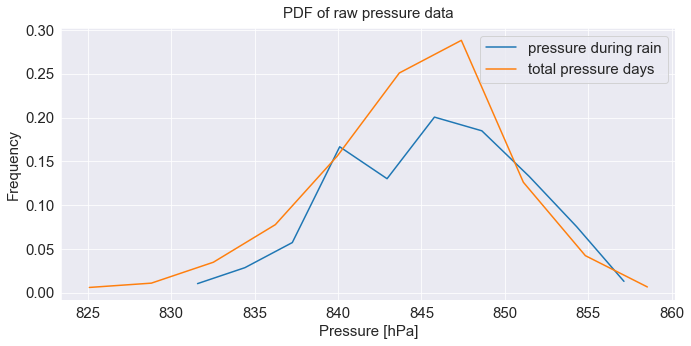

In [7]:
pres_r = pres[mask];
fig=plt.figure(figsize=(11,5));ax=fig.add_subplot(111)
h1 = np.histogram(pres_r)
h2 = np.histogram(pres)
plt.plot(h1[1][0:-1],h1[0]/np.size(pres_r),label='pressure during rain')
plt.plot(h2[1][0:-1],h2[0]/np.size(pres),label='total pressure days')
plt.legend();plt.xlabel('Pressure [hPa]');plt.ylabel('Frequency');
plt.title('PDF of raw pressure data');
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW2/figs/P1a.png',dpi=200,bbox_inches='tight')

**b) Using a t/z-test, employ a standard hypothesis test to determine whether the local pressure is anomalously
high or low during times when it is precipitating (R > 0). Describe all of your steps. Do you think that a
t-test/z-test is appropriate in this situation?**

1. Confidence level $\alpha$ = 0.05. Two tailed test because the pressure is high or low.
2. $H_o$: pressure is not anamolously (low or high) when it is raining.
3. The z-score, which assumes the following assumptions:
    - each pressure value is independent from one another 
    - the underlying distribution is normally distributed
4. The critical z value $z_c$: +-1.96 for the 95% confidence interval with standard normal
5. $z_c$ = +-1.96

Since the z-score falls outside of the critical z value range, we reject the null hypothesis that pressure is not anomalously low or high when it is raining.

In [8]:
# compare average pressure when raining, to population over 2014
z = (np.mean(pres_r) - np.mean(pres))/(np.std(pres)/np.sqrt(np.size(pres_r)));
print('z-score: ',z)

z-score:  2.4349481174347187


**c) Instead of the t/z-test, use bootstrap sampling to determine whether the local pressure is anomalously high
or low during times when it is precipitating. How does your answer compare with your results from Part
(b)? What does this tell you about your conclusion in Part (b)?**

- constructing a number of resamples of the original dataset (and of equal size to the observed sample of interest) by random sampling with replacement from the original dataset.
- with bootstrapping we are not assuming any underlying distribution
- can now quantify the likelihood of getting your value of PR>0 by chance alone using percentiles of the distribution of PN.

**Answer**
- By doing bootstrapping, we are taking N subsamples of the original data, taking the mean of those subsamples and plotting the distribution of the N average pressures during rain events. This way we are not assuming anything about the underlying distribution of the original data. Along with this we can plot the 95% confidence interval of the sample mean distribution. This plot below tells us the probability by CHANCE of getting our $P_N$, is very rare given the orange line (pressure during rain events) is outside  confidence interval. Therefore we reject the $H_o$ again, which is we reject the hypothesis that the pressure is not anomalously low or high when it is raining.
- Using a bootstrap example, we come to the same conclusion than with the z-test. By utilizing the central limit theorem for this sample of N=100, we can approximate the sample means distribution as a normal distribution and therefore our answer is the same as the z-test where we assumed a normal distribution and independent events.

In [13]:
presr_dist.shape

(10000,)

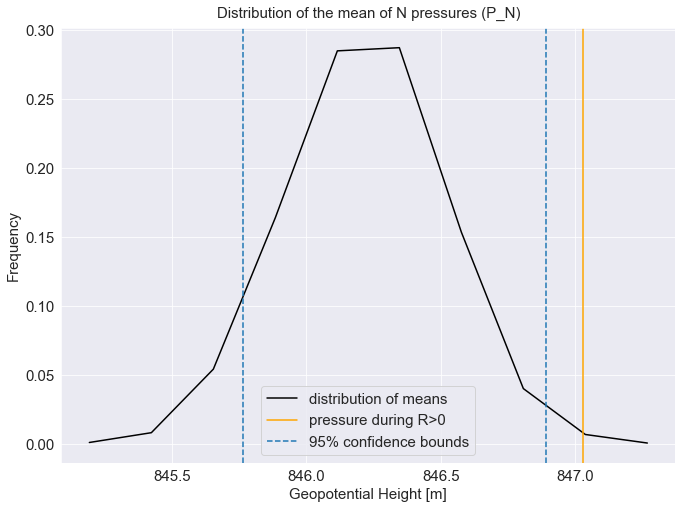

In [11]:
# bootstrapping
N = np.size(pres_r)
presr_dist = np.zeros(10000)
# take N random choices from pressure when it is raining and average
for i in np.arange(0,10000):
    presr_dist[i] = np.average(np.random.choice(np.squeeze(pres),N,replace=True))
    # with replacement, assuming that each pressure is independent
    
# plot distribution of sample average pressure 
hp = np.histogram(presr_dist)
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)
z1 = np.percentile(presr_dist-0.,2.5)
z2 = np.percentile(presr_dist-0.,100.-2.5)
plt.plot(hp[1][0:-1],hp[0]/np.size(presr_dist),color='k',label='distribution of means');
# plt.axvline(np.mean(presr_dist),color='k',linestyle='--',label='mean of distribution')
plt.axvline(presr_avg,color='orange',label='pressure during R>0')
plt.xlabel('Geopotential Height [m]');
plt.ylabel('Frequency');plt.title('Distribution of the mean of N pressures (P_N)');
plt.axvline(z1,linestyle='--',label='95% confidence bounds')
plt.axvline(z2,linestyle='--')
plt.legend();
# plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW2/figs/P1c.png',dpi=200,bbox_inches='tight')

### Problem 2

**a) Use hypothesis testing, can you reject the null hypothesis that the air is actually pristine air from the west
(H0 : μ = 0)? Use a two-tailed confidence interval of 95%.**

Ho = air is pristine and from the west

In [10]:
xbar = 0.13
mu = 0
sigma = 1
z = (xbar - mu)/(sigma/np.sqrt(100));z
# z score is 1.3

1.3

**Answer:** Z is 1.3 and falls within the boundars of the 95% confidence interval of a z-critical value of -1.96 and +1.96. Therefore, we cannot reject the null hypothesis Ho.

**b) You start discussing your issue with a graduate student in the department. They don’t know which way
the wind was recently blowing, but they do point you toward the Iowa Environmental Mesonet website
which provides information about the annual-mean wind directions (see Figure 1). Analyzing the wind rose
information, you see that the winds blow out of the west (between SW and NW) 40% of the time and that
the winds blow out of the east (between NE and SE) 60% of the time.7
Let γ denote the fraction of time the air comes from the west (so, γ = 0.4). **Use Bayes’ Theorem to compute
the probability that the air came from the west over your 100-sample period.**

$P(West|\bar C_{N_{100}}=0.13 ) = \frac{P(\bar C_{N_{100}}=0.13|West)*P(West)}{P(\bar C_{N_{100}}=0.13|West)*P(West) + P(\bar C_{N_{100}}=0.13|East)*P(East)}$

We cannot actually solve for $Pr(C_{N_{100}})=0.13$ therefore we reformat the problem into $Pr(West|0.13 − δ <= C100 <= 0.13 + δ)$

$P(West|\bar C_{N_{100}}=0.13 ) = \frac{P(0.14>\bar C_{N_{100}}>0.13|West)*P(West)}{P(0.14>\bar C_{N_{100}}>0.13|West)*P(West) + P(0.14>\bar C_{N_{100}}>0.13|East)*P(East)}$

**Discussion and Answer**

- Question: Do you think the wind from the last 100 samples was from the west or the east?

- We know the anomalous nitrogen contentrations from the west follow a normal distribution with $\mu_W$ = 0.0 and $\sigma_W$ = 1 and the concentrations from the east follow a normal distribution with $\mu_E$ = 0.2 and $\sigma_E$ = 1. We also know that the average of the Nitrogen concentration samples of the air for 100 samples was $\bar C_{100} = 0.13$. Since the average Nitrogen concentration are from initially a normal distribution, | Because we have a sample size of 100 > 30, we can use the central limit theorem to find to figure out distribution of sample means is a normal with sample mean = population mean and standard deviation = population standard deviation/sqrt(N), where N=100. So instead of trying to calculate $Pr(C_{N_{100}}=0.13|West)$, we can now calculate $P(0.14>\bar C_{N_{100}}>0.13|West)$ and similarly for East, **now knowing** the distribution for the sample means of average nitrogen concentrations.

In [11]:
mu_E = 0.2
sig_E = 1
mu_W = 0
sig_W = 1
p_west = 0.4
p_east = 0.6
N=100
Cbar = 0.13
delta = 0.01

p_Cwest = stats.norm.cdf(Cbar+delta, loc=mu_W,scale=sig_W/np.sqrt(N)) \
- stats.norm.cdf(Cbar-delta, loc=mu_W,scale=sig_W/np.sqrt(N))

p_Ceast = stats.norm.cdf(Cbar+delta, loc=mu_E,scale=sig_E/np.sqrt(N)) \
- stats.norm.cdf(Cbar-delta, loc=mu_E,scale=sig_W/np.sqrt(N))

p_bayes = (p_Cwest*p_west)/(p_Cwest*p_west + p_Ceast*p_east)
print('Probability of Bayes: ',round(p_bayes,2),'or 27 %')

Probability of Bayes:  0.27 or 27 %


**c) Explain your results and what they imply about the two different methods. Be sure to specifically discuss
the behavior in the limits of large and small γ.**
$\gamma$ = fraction of time wind comes from direction
$\gamma$ = 0.4. 40% of time wind comes from west.

**Discussion and Answer**
- We see that the Bayesian approach has a 100% frequency of getting the correct answer at each extreme and a dip in the middle, while the Frequentist has a very high (~95% frequency) of getting the correct answer at $\gamma$=1.0 and a lower frequency at $\gamma$=0.
- It makes sense that the Bayesian approach has a higher frequency of getting the correct answer closer to the extremes of $\gamma$ because we have more information (we are more sure of which direction the wind is coming from). At $\gamma$ = 0.2 for example, we are more sure that the wind is coming out of the east. Similarly, at $\gamma$ = 0.8, we are most sure that the wind is coming out of the west, where if $\gamma$ = 0.5, we are less sure where the wind is coming from. Mathematically, a $\gamma$ closer to the extremes will output a smaller denominator and a higher probability value for Bayes approach, than if $\gamma$ = 0.5.
- In the frequentist approach, we see that even for a $\gamma$ = 1 that the frequency of guessing the correct direction is not 100%, rather it is 95% due to our 95% confidence interval, such that we reject anything in the extreme 5% of the distribution. At $\gamma$ = 0, we see a 50% probability of getting the correct answer due to the underlying distribution of the wind.

In [12]:
# my code
tic()
gamma_array = np.arange(0,1.1,0.1)
n = 100
n_exp = 5000
frequentist = np.zeros([np.size(gamma_array),n_exp])
bayesian = np.zeros([np.size(gamma_array),n_exp])
alpha=0.05
delta=0.01

for i,gamma in enumerate(gamma_array): # each gamma 0.1, 0.2, ...
    
    for j in np.arange(0,n_exp): # number of experiments
        ##### Frequentist #####
        # choose random value
        random_val = stats.uniform.rvs()
        if random_val <= gamma: # wind from west
            from_west = 1
            cbar = np.mean(stats.norm.rvs(size=n, loc=mu_W, scale=sig_W))
        else: # wind from east
            from_west = 0
            cbar = np.mean(stats.norm.rvs(size=n, loc=mu_E, scale=sig_E)) 
        # calculate z-crit,z-score
        zcrit = stats.norm.ppf(alpha/2, loc = 0, scale = 1) # percent point function [alpha, mean, stddev] std normal assumed
        zscore = (cbar - mu_W)/(sig_W/np.sqrt(n)) # comparing concentration of nitrogen to dist of wind from W
        
        if (zscore < zcrit or zscore > -zcrit): # reject Ho and think winds are from east
            if from_west == 0: # "truth"
                frequentist[i,j] = 1
            else:
                frequentist[i,j] = 0
        else: # winds from west
            if from_west == 0:
                frequentist[i,j] = 0
            else:
                frequentist[i,j] = 1
        ##### Bayesian #####
        
        pWest = gamma
        pEast = 1-gamma
        prob_west =  stats.norm.cdf(cbar+delta, loc=mu_W,scale=sig_W/np.sqrt(n)) \
                   - stats.norm.cdf(cbar-delta, loc=mu_W,scale=sig_W/np.sqrt(n))
        prob_east =  stats.norm.cdf(cbar+delta, loc=mu_E,scale=sig_E/np.sqrt(n)) \
                   - stats.norm.cdf(cbar-delta, loc=mu_E,scale=sig_E/np.sqrt(n))
        pbayes = (prob_west*pWest)/(prob_west*pWest + prob_east*pEast)
        if pbayes >= 0.5: # west winds
            if from_west == 0:
                bayesian[i,j] = 0
            else:
                bayesian[i,j] = 1
        else:
            if from_west == 0: # east winds 
                bayesian[i,j] = 1
            else:
                bayesian[i,j] = 0
toc()

Elapsed time is 25.963755130767822 seconds.


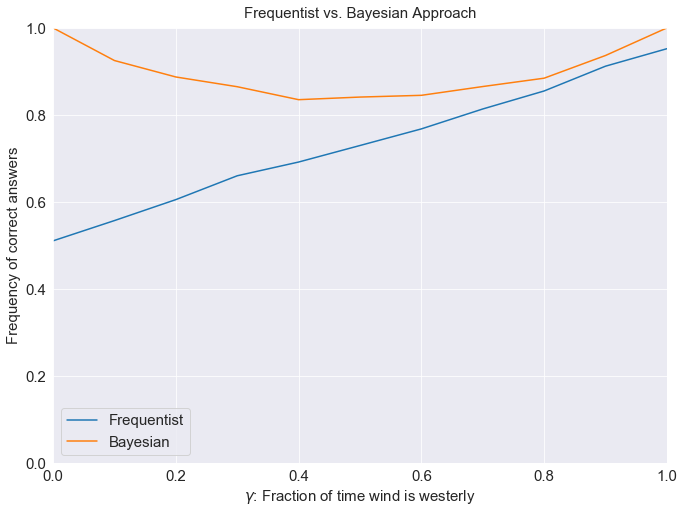

In [13]:
# plotting 
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(111)

plt.plot(gamma_array,np.sum(frequentist/n_exp,axis=1),label='Frequentist') # at each gamma, sum up experiments
plt.plot(gamma_array,np.sum(bayesian/n_exp,axis=1),label='Bayesian') # at each gamma, sum up experiments
plt.ylim([0,1]);plt.xlim([0,1]);
plt.legend();plt.xlabel(r'$\gamma$: Fraction of time wind is westerly');
plt.ylabel('Frequency of correct answers');plt.title('Frequentist vs. Bayesian Approach');
plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW2/figs/P2c.png',dpi=200,bbox_inches='tight')